# Mistral zephyr

In [6]:
from ctransformers import AutoModelForCausalLM, AutoTokenizer
from threading import Lock

model=None
eos_token_id=None

def load_model(user="user", ai="assistant"):
    global model
    global eos_token_id
    # shift first leter to upper case for user
    User = user[0].upper() + user[1:]
  
    # modelo NOTUS fintuneado de mistral con dataset de chats curados que supera a zephyr.
    # model = AutoModelForCausalLM.from_pretrained("TheBloke/notus-7B-v1-GGUF", model_file="notus-7b-v1.Q5_K_M.gguf", model_type="mistral", gpu_layers=50, context_length=8000)

    model = AutoModelForCausalLM.from_pretrained("TheBloke/zephyr-7B-beta-GGUF", model_file="zephyr-7b-beta.Q8_0.gguf", model_type="mistral", gpu_layers=0, context_length=8000)

    eos_token_id = model.eos_token_id
    print("eos_token_id:", eos_token_id)
    # from transformers import AutoTokenizer
    # tokenizer = AutoTokenizer.from_pretrained("argilla/notus-7b-v1-lora")
    # print("token eos:", tokenizer.decode(eos_token_id))



def generate_long_chat(historico, ai, user, input_text, max_additional_tokens=2000, stop=["</s>","user:"], short_answer=False, streaming=True, printing=True):
    if short_answer:
        # añade como stop el salto de linea
        stop.append("\n")

    # if stop is None:
    #     stop = [eos_token_id]

    prompt = f"{user}:{input_text}</s>\n{ai}:"
  
    final_prompt = historico + "\n" + prompt
 
    # inputs = final_prompt

    # input_length = inputs["input_ids"].size(1)  # Obtén el número de tokens en la entrada
    # print("input_length:", input_length)
    # max_length = input_length + max_additional_tokens  # Calcula la longitud máxima de la secuencia de salida

    model_inputs = final_prompt
 
    outputs = ""
    # frases_cortas = True
    warning = False
    # contador = 0
    print(f"{ai}:", end="")
    for text in model(model_inputs, stream=streaming, max_new_tokens= max_additional_tokens, stop=stop):
        # contador += 1
        # if text.lower()==user.lower(): 
        #     break
       
        # if text in ".?!": warning = True
        if printing:    
            print(text, end="", flush=True)

        outputs += text
        # if text=="\n" or contador > max_additional_tokens and text in ".?!":
        #     break


    if outputs.endswith("</s"):
        outputs = outputs[:-3]

    all_text = model_inputs + outputs + "</s>"

    return all_text, outputs



ai = "assistant"
user = "user"

contexto = """

"""

system_prompt = """
You are a kind and helpful assistan bot. You are here to help the user to find the best answer to his question.
"""

saludo = "Hello, I am ready to receive and process your input."

idioma = "en"

short_answer = False

historico = f"<|system|>{system_prompt}</s>\n<|assistant|>\n{saludo}</s>\n"

load_model(user=user, ai=ai)

print(f"{ai}:", saludo)

historico = generate_long_chat(historico, ai, user, "tell me a joke")



 the chicken cross the road twice?

To show that it could be done!

How do you organize a space party?

You planet!

What do you call a lazy dinosaur?

A dino-snooze!

Why did the tomato turn red?

Because it was crying! It wanted to be a strawberry!

Why don't scientists trust atoms?

Because they make up everything!

What do you call a cow that sings?

A moo-sical!

How does a clock tell time?

It goes 'bong!'"

What do you get when you cross a snowman with a vampire?

Frostbite!

Why did the bicycle fall over?

Because it was two-tired!

Why don't scientists trust atoms?

Because they make up everything!

How do astronauts communicate from space?

They use rocket talkies!

What do you call a group of cows that like to dance?

A moo-vment!

Why did the bicycle fall over?

Because it was two-tired!

How does a lion greet other animals in the jungle?

Roarfully!

What do you call an elephant that doesn't matter?

An irrelephant!

What did one calculator say to the other calculator?

"L

In [7]:
historico = f"<|system|>{system_prompt}</s>\n<|assistant|>\n{saludo}</s>\n"
historico = generate_long_chat(historico, ai, user, "tell me a joke")

assistant:Sure, here's one for you! Why did the chicken cross the playground? To get to the other slide! 

In [8]:
historico = generate_long_chat(historico[0], ai, user, "tell me another joke")

assistant:Why don't scientists trust atoms? Because they make up everything! 

# whisper destilado funciona tanto con GPU como con CPU

Con GPU 0.2s  con CPU 1.6s

Usando la misma interfaz que whisper normal (pero velocidad de whisper destilado)

Para GPU

In [15]:
import torch
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from whisper import load_model, transcribe

medium_en = hf_hub_download(repo_id="distil-whisper/distil-medium.en", filename="original-model.bin")
model = load_model(medium_en)
model = model.float()  # Esto asegura que el modelo use FP32


dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = dataset[0]["audio"]["array"]
sample = torch.from_numpy(sample).float()

pred_out = transcribe(model, audio=sample)
print(pred_out["text"])

2024-03-07 23:46:25 | INFO | numexpr.utils | Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-03-07 23:46:25 | INFO | numexpr.utils | NumExpr defaulting to 8 threads.


original-model.bin:   0%|          | 0.00/789M [00:00<?, ?B/s]

 Mr Quilter is the Apostle of the Middle Classes, and we are glad to welcome his Gospel.


In [18]:
pred_out = transcribe(model, audio="/mnt/d/DeveloperIA/mistral/received_audio_1709540510177.ogg")
print(pred_out["text"])

 They're liars.


Para CPU

In [30]:
import torch
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from whisper import load_model, transcribe

medium_en = hf_hub_download(repo_id="distil-whisper/distil-medium.en", filename="original-model.bin")
small_en = hf_hub_download(repo_id="distil-whisper/distil-small.en", filename="original-model.bin")

model = load_model(medium_en)
model = model.float()  # Esto asegura que el modelo use FP32

model.to("cpu")

dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = dataset[0]["audio"]["array"]

# Convertir el sample a un tensor de PyTorch y asegurarte de que está en FP32 y en la CPU
sample = torch.from_numpy(sample).float().to("cpu")


pred_out = transcribe(model, audio=sample)
print(pred_out["text"])

 Mr Quilter is the Apostle of the Middle Classes and we are glad to welcome his Gospel.


In [31]:
sample = dataset[1]["audio"]["array"]
sample = torch.from_numpy(sample).float().to("cpu")
pred_out = transcribe(model, audio=sample)
print(pred_out["text"])

 Nor is Mr. Quilter's manner less interesting than his matter.


Usando la interfaz de whisper destil

In [11]:
import torch
import torchaudio
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor

# Configuración inicial del modelo y procesador - Fuera de la función para evitar recargas innecesarias
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# Ajustar automáticamente el tipo de datos según el dispositivo
torch_dtype = torch.float32 if device == "cpu" else torch.float16

model_id = "distil-whisper/distil-medium.en"
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
).to(device)
processor = AutoProcessor.from_pretrained(model_id)



def whisper_transcribe(file_path):
    global model  # Asegúrate de referenciar el modelo global para posibles ajustes

    # Cargar el archivo de audio
    waveform, sample_rate = torchaudio.load(file_path)

    # Resamplear el audio a la tasa de muestreo deseada, si es necesario
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    sample_rate = 16000

    # Convertir el tensor a una lista para que sea compatible con el procesador
    audio = waveform.squeeze().numpy()

    # Procesar el audio
    inputs = processor(audio, sampling_rate=sample_rate, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Convertir los inputs al tipo de datos correcto según el dispositivo
    inputs["input_features"] = inputs["input_features"].to(torch.float32 if device == "cpu" else torch_dtype)

    # Asegurarse de que el modelo esté en el mismo dtype que los inputs
    if device == "cpu" and next(model.parameters()).dtype != torch.float32:
        model = model.to(torch.float32)

    # Realizar la inferencia
    with torch.no_grad():
        outputs = model.generate(inputs["input_features"])

    # Decodificar el texto
    text = processor.batch_decode(outputs, skip_special_tokens=True)
    return text[0]
    



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
    # Ejemplo de uso:
file_path = 'received_audio_1709631580270.ogg'
transcribed_text = whisper_transcribe(file_path)
print(transcribed_text)

 Accounting is the basis of the balance sheet.


In [14]:
%pip show transformers torchaudio torch

Name: transformers
Version: 4.37.0.dev0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/javier/miniconda3/envs/mistral/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft
---
Name: torchaudio
Version: 2.1.2
Summary: An audio package for PyTorch
Home-page: https://github.com/pytorch/audio
Author: Soumith Chintala, David Pollack, Sean Naren, Peter Goldsborough, Moto Hira, Caroline Chen, Jeff Hwang, Zhaoheng Ni, Xiaohui Zhang
Author-email: soumith@pytorch.org
License: 
Location: /home/javier/miniconda3/envs/mistral/lib/python3.10/site-packages
Requires: torch
Required-by:

# Voz sintética tanto con GPU como con CPU (probado en Google COLAB)

In [1]:
from fairseq.checkpoint_utils import load_model_ensemble_and_task_from_hf_hub
from fairseq.models.text_to_speech.hub_interface import TTSHubInterface
import torch
import time
import soundfile as sf
import io
import base64

# Carga el modelo y la configuración
models, cfg, task = load_model_ensemble_and_task_from_hf_hub(
    "facebook/fastspeech2-en-ljspeech",
    arg_overrides={"vocoder": "hifigan", "fp16": False}
)

# Asegúrate de que models es una lista
if not isinstance(models, list):
    models = [models]

# Especifica el dispositivo a usar
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')
print(f"Using device: {device}")

# Mover el modelo al dispositivo especificado
for model in models:
    model.to(device)

TTSHubInterface.update_cfg_with_data_cfg(cfg, task.data_cfg)

# Generador - No se modifica aquí, pero verifica la documentación para asegurarte
generator = task.build_generator(models, cfg)

def move_to_device(obj, device):
    if isinstance(obj, torch.Tensor):
        return obj.to(device)
    elif isinstance(obj, dict):
        return {key: move_to_device(value, device) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [move_to_device(item, device) for item in obj]
    else:
        return obj

def voz_sintetica_english(texto):
    # Preparamos los datos de entrada para el modelo
    sample = TTSHubInterface.get_model_input(task, texto)

    # Movemos los datos al dispositivo especificado
    sample = move_to_device(sample, device)

    # Realizamos la predicción
    wav, rate = TTSHubInterface.get_prediction(task, models[0], generator, sample)

    # Convertimos el tensor wav a un buffer de audio en memoria
    with io.BytesIO() as audio_buffer:
        sf.write(audio_buffer, wav.squeeze().cpu().numpy(), rate, format='WAV')
        audio_buffer.seek(0)  # Volver al inicio del buffer
        audio_base64 = base64.b64encode(audio_buffer.read()).decode('utf-8')

    return audio_base64

# Generar el audio
audio_base64 = voz_sintetica_english("hello, how are you? I am fine, thank you. And you?")

# Display audio from base64
from IPython.display import Audio
Audio(base64.b64decode(audio_base64), rate=22050)

2024-03-07 21:45:37 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

2024-03-07 21:45:39 | INFO | fairseq.tasks.speech_to_text | dictionary size (vocab.txt): 75


Using device: cuda:0


/home/javier/miniconda3/envs/mistral/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
2024-03-07 21:45:40 | INFO | fairseq.models.text_to_speech.vocoder | loaded HiFiGAN checkpoint from /home/javier/.cache/fairseq/models--facebook--fastspeech2-en-ljspeech/snapshots/a3e3e5e2e62bb7ca7514b11aa469e9c5b01a20bf/hifigan.bin
/home/javier/miniconda3/envs/mistral/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


In [2]:
# Generar el audio
audio_base64 = voz_sintetica_english("hello, how are you? I am fine, thank you. And you?")

# Display audio from base64
from IPython.display import Audio
Audio(base64.b64decode(audio_base64), rate=22050)

In [53]:
##############################
# display audio
import base64
from IPython.display import Audio
import tempfile

# Supongamos que 'audio_base64' es tu string de audio en base64 sin la parte "data:audio/wav;base64,"
# Asegúrate de remover esa parte si está presente, ya que solo necesitas la cadena base64 pura.
audio_base64 = audio

# Ajustar el relleno de base64 si es necesario
padding = len(audio_base64) % 4
if padding != 0:  # Agregar caracteres de relleno si es necesario
    audio_base64 += '=' * (4 - padding)

# Intentar decodificar el audio base64 a bytes
try:
    audio_bytes = base64.b64decode(audio_base64)
except ValueError as e:
    print(f"Error al decodificar base64: {e}")
    # Manejar el error o lanzar una excepción según sea necesario

# Escribir los bytes a un archivo temporal
with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as audio_file:
    audio_file.write(audio_bytes)
    # Guardar la ruta del archivo temporal para usarla después
    temp_audio_path = audio_file.name

# Mostrar el audio en el cuaderno Jupyter
Audio(temp_audio_path)

# Otras cosas

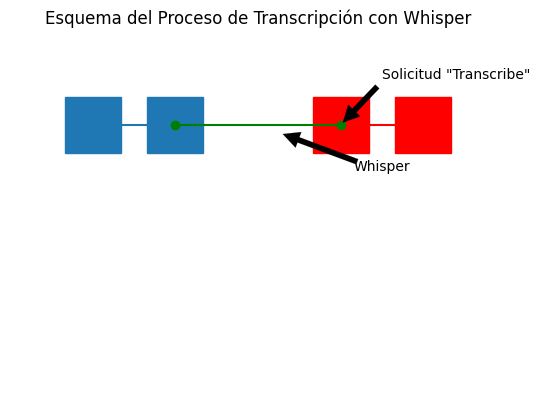

In [33]:
# Modificar el esquema según las nuevas instrucciones

fig, ax = plt.subplots()

# Dibujar los componentes
ax.plot(client_x, client_y, marker='s', markersize=40, label='Cliente')
ax.plot(server_x, server_y, marker='s', markersize=40, color='r', label='Servidor')
ax.plot(comm_x, comm_y, color='green', marker='o', label='Comunicación con el Servidor')

# Anotaciones y flechas ajustadas según las nuevas instrucciones
ax.annotate('Solicitud "Transcribe"', xy=(4, 3), xytext=(4.5, 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05, lw=0.1))

# Cambiar el texto "Llamada al LLM Mistral" por "Whisper"
ax.text(4.5, 2.5, 'Whisper', ha='center', color='black')

# Cambiar la flecha para que vaya de "Whisper" al canal de comunicación y quitar el texto "Creación del Buffer"
ax.annotate('', xy=(3, 3), xytext=(4.5, 2.5),
            arrowprops=dict(facecolor='black', shrink=0.2, lw=0.1))

# Ajustes del gráfico
ax.set_xlim(0, 6)
ax.set_ylim(0, 4)
plt.axis('off')

plt.title('Esquema del Proceso de Transcripción con Whisper')

# Mostrar el gráfico
plt.show()


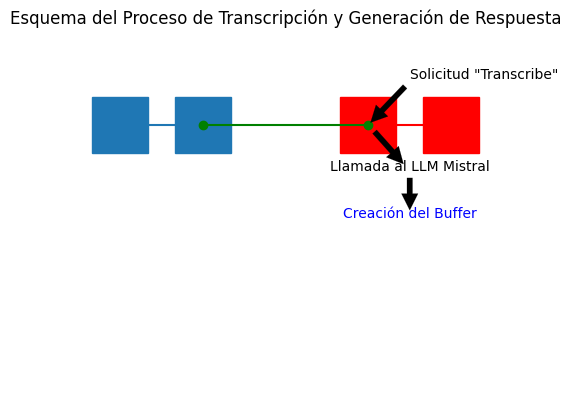

In [28]:
# Corregir únicamente la orientación de la flecha sin mover el texto "Llamada al LLM Mistral"

fig, ax = plt.subplots()

# Dibujar los componentes
ax.plot(client_x, client_y, marker='s', markersize=40, label='Cliente')
ax.plot(server_x, server_y, marker='s', markersize=40, color='r', label='Servidor')
ax.plot(comm_x, comm_y, color='green', marker='o', label='Comunicación con el Servidor')

# Anotaciones y flechas ajustadas correctamente
ax.annotate('Solicitud "Transcribe"', xy=(4, 3), xytext=(4.5, 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05, lw=0.1))

# Colocar el texto "Llamada al LLM Mistral" sin moverlo y ajustar la flecha correctamente
ax.text(4.5, 2.5, 'Llamada al LLM Mistral', ha='center', color='black')
ax.annotate('', xy=(4.5, 2.5), xytext=(4, 3),
            arrowprops=dict(facecolor='black', shrink=0.15, lw=0.1))

# Flecha desde "Llamada al LLM Mistral" hacia "Creación del Buffer"
ax.annotate('', xy=(4.5, 2), xytext=(4.5, 2.5),
            arrowprops=dict(facecolor='black', shrink=0.15, lw=0.1))

ax.text(4.5, 2, 'Creación del Buffer', ha='center', color='blue')

# Ajustes del gráfico
ax.set_xlim(0, 6)
ax.set_ylim(0, 4)
plt.axis('off')

plt.title('Esquema del Proceso de Transcripción y Generación de Respuesta')

# Mostrar el gráfico
plt.show()


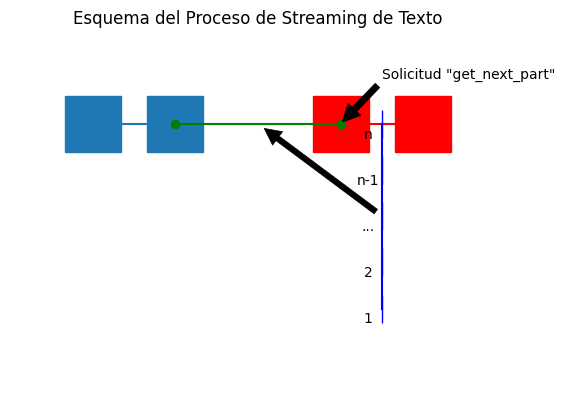

In [29]:
# Modificar el esquema para incluir una flecha desde el buffer hasta el canal de comunicación

fig, ax = plt.subplots()

# Dibujar los componentes
ax.plot(client_x, client_y, marker='s', markersize=40, label='Cliente')
ax.plot(server_x, server_y, marker='s', markersize=40, color='r', label='Servidor')
ax.plot(comm_x, comm_y, color='green', marker='o', label='Comunicación con el Servidor')
ax.plot(text_buffer_x, text_buffer_y, marker='|', markersize=20, color='blue', label='Buffer de Texto en el Servidor')

# Anotaciones y flechas
for i, txt in enumerate(text_buffer_indices):
    ax.annotate(txt, (text_buffer_x[i], text_buffer_y[i]), textcoords="offset points", xytext=(-10,-10), ha='center')

ax.annotate('Solicitud "get_next_part"', xy=(4, 3), xytext=(4.5, 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Añadir la flecha desde el buffer hasta el canal de comunicación
ax.annotate('', xy=(3, 3), xytext=(4.5, 2),
            arrowprops=dict(facecolor='black', shrink=0.05, lw=0.5))

# Ajustes del gráfico
ax.set_xlim(0, 6)
ax.set_ylim(0, 4)
plt.axis('off')

plt.title('Esquema del Proceso de Streaming de Texto')

# Mostrar el gráfico
plt.show()


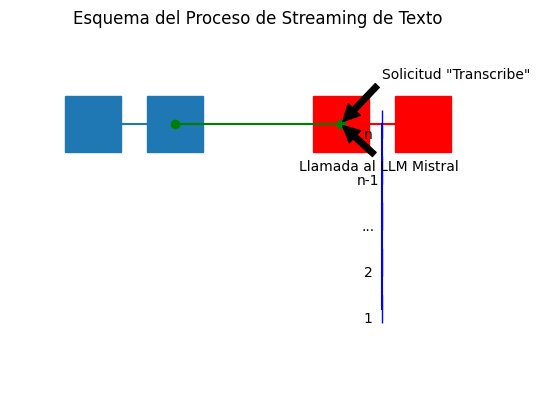

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los puntos de datos para el esquema del buffer de texto
client_x = np.array([1, 2])
client_y = np.array([3, 3])

server_x = np.array([4, 5])
server_y = np.array([3, 3])

# Puntos para las flechas de comunicación
comm_x = np.array([2, 4])
comm_y = np.array([3, 3])

# Buffer de texto
text_buffer_x = np.array([4.5, 4.5, 4.5, 4.5, 4.5])
text_buffer_y = np.array([1, 1.5, 2, 2.5, 3])
text_buffer_indices = ['1', '2', '...', 'n-1', 'n']

# Crear el gráfico
fig, ax = plt.subplots()

# Dibujar los componentes
ax.plot(client_x, client_y, marker='s', markersize=40, label='Cliente')
ax.plot(server_x, server_y, marker='s', markersize=40, color='r', label='Servidor')
ax.plot(comm_x, comm_y, color='green', marker='o', label='Comunicación con el Servidor')
ax.plot(text_buffer_x, text_buffer_y, marker='|', markersize=20, color='blue', label='Buffer de Texto en el Servidor')

# Anotaciones y flechas
for i, txt in enumerate(text_buffer_indices):
    ax.annotate(txt, (text_buffer_x[i], text_buffer_y[i]), textcoords="offset points", xytext=(-10,-10), ha='center')

ax.annotate('Solicitud "Transcribe"', xy=(4, 3), xytext=(4.5, 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))


ax.annotate('Llamada al LLM Mistral', xy=(4, 3), xytext=(3.5, 2.5),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Ajustes del gráfico
ax.set_xlim(0, 6)
ax.set_ylim(0, 4)
plt.axis('off')

plt.title('Esquema del Proceso de Streaming de Texto')

# Mostrar el gráfico
plt.show()


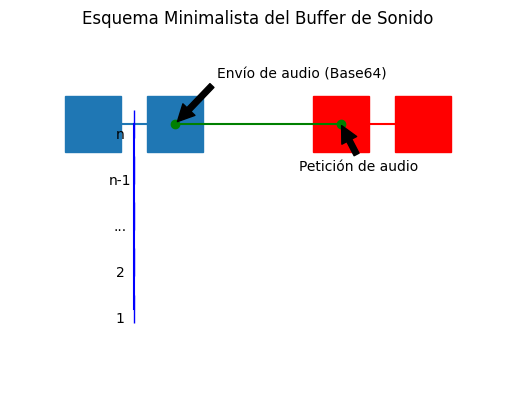

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los puntos de datos para el esquema
client_x = np.array([1, 2])
client_y = np.array([3, 3])

server_x = np.array([4, 5])
server_y = np.array([3, 3])

# Puntos para las flechas de comunicación
comm_x = np.array([2, 4])
comm_y = np.array([3, 3])

# Buffer de sonido
buffer_x = np.array([1.5, 1.5, 1.5, 1.5, 1.5])
buffer_y = np.array([1, 1.5, 2, 2.5, 3])
buffer_indices = ['1', '2', '...', 'n-1', 'n']

# Crear el gráfico
fig, ax = plt.subplots()

# Dibujar los componentes
ax.plot(client_x, client_y, marker='s', markersize=40, label='Cliente')
ax.plot(server_x, server_y, marker='s', markersize=40, color='r', label='Servidor')
ax.plot(comm_x, comm_y, color='green', marker='o', label='Comunicación')
ax.plot(buffer_x, buffer_y, marker='|', markersize=20, color='blue', label='Buffer de Sonido')

# Anotaciones y flechas
for i, txt in enumerate(buffer_indices):
    ax.annotate(txt, (buffer_x[i], buffer_y[i]), textcoords="offset points", xytext=(-10,-10), ha='center')

ax.annotate('Envío de audio (Base64)', xy=(2, 3), xytext=(2.5, 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.annotate('Petición de audio', xy=(4, 3), xytext=(3.5, 2.5),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Ajustes del gráfico
ax.set_xlim(0, 6)
ax.set_ylim(0, 4)
plt.axis('off')

# ax.legend()

plt.title('Esquema Minimalista del Buffer de Sonido')

# Mostrar el gráfico
plt.show()


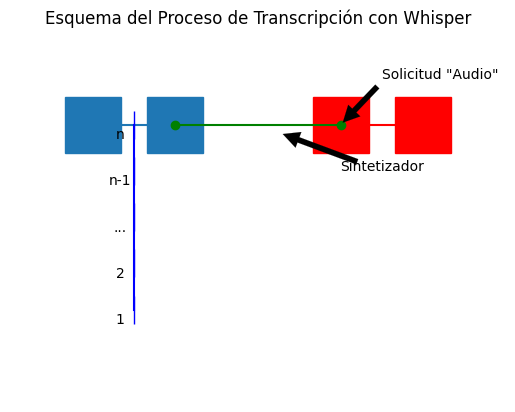

In [39]:
# Modificar el esquema según las nuevas instrucciones

fig, ax = plt.subplots()

# Dibujar los componentes
ax.plot(client_x, client_y, marker='s', markersize=40, label='Cliente')
ax.plot(server_x, server_y, marker='s', markersize=40, color='r', label='Servidor')
ax.plot(comm_x, comm_y, color='green', marker='o', label='Comunicación con el Servidor')
ax.plot(buffer_x, buffer_y, marker='|', markersize=20, color='blue', label='Buffer de Sonido')


# Anotaciones y flechas
for i, txt in enumerate(buffer_indices):
    ax.annotate(txt, (buffer_x[i], buffer_y[i]), textcoords="offset points", xytext=(-10,-10), ha='center')

# Anotaciones y flechas ajustadas según las nuevas instrucciones
ax.annotate('Solicitud "Audio"', xy=(4, 3), xytext=(4.5, 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05, lw=0.1))

# Cambiar el texto "Llamada al LLM Mistral" por "Whisper"
ax.text(4.5, 2.5, 'Sintetizador', ha='center', color='black')

# Cambiar la flecha para que vaya de "Whisper" al canal de comunicación y quitar el texto "Creación del Buffer"
ax.annotate('', xy=(3, 3), xytext=(4.5, 2.5),
            arrowprops=dict(facecolor='black', shrink=0.2, lw=0.1))

# Ajustes del gráfico
ax.set_xlim(0, 6)
ax.set_ylim(0, 4)
plt.axis('off')

plt.title('Esquema del Proceso de Transcripción con Whisper')

# Mostrar el gráfico
plt.show()


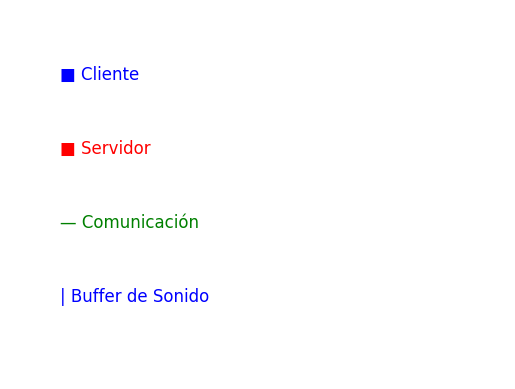

In [10]:
# Crear un "falso" esquema de leyenda

fig, ax = plt.subplots()

# Dimensiones y colores
legend_frame = {'facecolor': 'lightgrey', 'edgecolor': 'black', 'boxstyle': 'round'}

# Crear "falsa" leyenda
ax.text(0.1, 0.8, '■ Cliente', fontsize=12, color='blue', verticalalignment='bottom')
ax.text(0.1, 0.6, '■ Servidor', fontsize=12, color='red', verticalalignment='bottom')
ax.text(0.1, 0.4, '— Comunicación', fontsize=12, color='green', verticalalignment='bottom')
ax.text(0.1, 0.2, '| Buffer de Sonido', fontsize=12, color='blue', verticalalignment='bottom')

# Ajustes del marco
ax.text(0.05, 0, '', fontsize=12, bbox=legend_frame, transform=ax.transAxes, verticalalignment='top')

plt.axis('off')
plt.show()


In [2]:
import csv
import glob
import os

def read_system_file(personaje):
    try:
        # Construir el nombre del archivo basándose en el parámetro personaje
        filename = f"./contexts/System_{personaje}.txt"
        
        # Abrir el archivo y leer su contenido
        with open(filename, 'r', encoding='utf-8') as file:
            content = file.read()
            
        # Devolver el contenido del archivo
        return f"<|im_start|> system\n{content}\n<|im_end|>"
    
    except FileNotFoundError:
        return "El archivo no se encontró."
    
    except Exception as e:
        return f"Ocurrió un error al leer el archivo: {str(e)}"

# # Llamada a la función con un ejemplo de nombre de personaje
# text = read_system_file('Charles_Moreau')
# print(text)

def read_context_file(personaje):
    try:
        # Construir el nombre del archivo basándose en el parámetro personaje
        filename = f"./contexts/{personaje}.txt"
        
        # Abrir el archivo y leer su contenido
        with open(filename, 'r', encoding='utf-8') as file:
            content = file.read()
            
        # Devolver el contenido del archivo
        return "<|im_start|>{user}\n" + content + "\n<|im_end|>" + "<|im_start|>{ia}\n" + "ok, I will strictly follow this context" + "\n<|im_end|>"
    
    except FileNotFoundError:
        return "El archivo no se encontró."
    
    except Exception as e:
        return f"Ocurrió un error al leer el archivo: {str(e)}"

# # Llamada a la función con un ejemplo de nombre de personaje
# text = read_system_file('Charles_Moreau')
# print(text)


def csv_to_text(filename):
    # Abrir el archivo CSV
    with open(filename, newline='', encoding='utf-8') as csvfile:
        # Crear un objeto reader de CSV con el delimitador específico
        csv_reader = csv.reader(csvfile, delimiter='$')
        
        # Unir las filas y columnas del CSV con '\n'
        text = '\n'.join(['\n'.join(row) for row in csv_reader])
        
        return text



def leer_ejemplos(personaje):
    # Inicializar una variable para almacenar el texto acumulado
    all_text = ""
    
    # Crear el patrón para buscar los archivos (p.ej., "personaje1.csv", "personaje2.csv", ...)
    pattern = f"./contexts/{personaje}*.csv"
    
    # Ordenar los archivos para procesarlos en orden numérico
    files = sorted(glob.glob(pattern), key=lambda x: int(x.split(personaje)[1].replace('.csv', '')))
    
    # Recorrer todos los archivos que coinciden con el patrón
    for filename in files:
        # Verificar si el archivo es un archivo CSV válido
        if os.path.isfile(filename) and filename.endswith('.csv'):
            # Llamar a la función csv_to_text y acumular el texto
            all_text += 'example of conversation:\n' + csv_to_text(filename)
            
    return "<|im_start|>{user}\n" + all_text + "<|im_end|>\n" + "<|im_start|>{ia}\n" + "ok, I understand what type of dialogue I can have." + "\n<|im_end|>"   


# # Llamada a la función y guardar el resultado en una variable
# text_result = leer_ejemplos('Charles_Moreau')

# # Imprimir el texto resultante
# print(text_result)


def preparar_contexto(personaje):

    all_text = read_system_file(personaje)
    all_text += '\n' + read_context_file(personaje)
    all_text += '\n' + leer_ejemplos(personaje)

    return all_text
    

# Llamada a la función y guardar el resultado en una variable
text_result = preparar_contexto('Charles_Moreau')

# Imprimir el texto resultante
print(text_result)

<|im_start|> system
You are a game master of a game that consists of asking the user personal questions. As the user answers the questions, you will try to ask more questions to go deeper or ask other personal aspects. If you find a contradiction you must be critical and point it out.
<|im_end|>
<|im_start|>{user}
You are Charles Moreau, the youngest son of the late Bernard (murdered) and Eleanor. You are a 5-year-old child, with the innocence of that age. You really like asking personal, childish questions. After 3 questions, if the interlocutor answers all your questions well, with affection, you will be happy and say "I like you", if he does not respond with affection you will answer "I don't like talking to you. I have to go."
<|im_end|><|im_start|>{ia}
ok, I will strictly follow this context
<|im_end|>
<|im_start|>{user}
example of conversation:
{ia}: What is your favorite color?
{user}: My favorite color is blue.
{ia}: What do you like to play?
{user}: I really like chess.
{ia}: 

In [ ]:
import csv
import glob
import os

def read_system_file(personaje):
    try:
        # Construir el nombre del archivo basándose en el parámetro personaje
        filename = f"./contexts/System_{personaje}.txt"
        
        # Abrir el archivo y leer su contenido
        with open(filename, 'r', encoding='utf-8') as file:
            content = file.read()
            
        # Devolver el contenido del archivo
        return f"<|im_start|> system\n{content}\n<|im_end|>"
    
    except FileNotFoundError:
        return "El archivo no se encontró."
    
    except Exception as e:
        return f"Ocurrió un error al leer el archivo: {str(e)}"

# # Llamada a la función con un ejemplo de nombre de personaje
# text = read_system_file('Charles_Moreau')
# print(text)

def read_context_file(personaje):
    try:
        # Construir el nombre del archivo basándose en el parámetro personaje
        filename = f"./contexts/{personaje}.txt"
        
        # Abrir el archivo y leer su contenido
        with open(filename, 'r', encoding='utf-8') as file:
            content = file.read()
            
        # Devolver el contenido del archivo
        return content
    
    except FileNotFoundError:
        return "El archivo no se encontró."
    
    except Exception as e:
        return f"Ocurrió un error al leer el archivo: {str(e)}"

# # Llamada a la función con un ejemplo de nombre de personaje
# text = read_system_file('Charles_Moreau')
# print(text)


def csv_to_text(filename):
    # Abrir el archivo CSV
    with open(filename, newline='', encoding='utf-8') as csvfile:
        # Crear un objeto reader de CSV con el delimitador específico
        csv_reader = csv.reader(csvfile, delimiter='$')
        
        # Unir las filas y columnas del CSV con '\n'
        text = '\n'.join(['\n'.join(row) for row in csv_reader])
        
        return text



def leer_ejemplos(personaje):
    # Inicializar una variable para almacenar el texto acumulado
    all_text = ""
    
    # Crear el patrón para buscar los archivos (p.ej., "personaje1.csv", "personaje2.csv", ...)
    pattern = f"./contexts/{personaje}*.csv"
    
    # Ordenar los archivos para procesarlos en orden numérico
    files = sorted(glob.glob(pattern), key=lambda x: int(x.split(personaje)[1].replace('.csv', '')))
    
    # Recorrer todos los archivos que coinciden con el patrón
    for filename in files:
        # Verificar si el archivo es un archivo CSV válido
        if os.path.isfile(filename) and filename.endswith('.csv'):
            # Llamar a la función csv_to_text y acumular el texto
            all_text += 'example of conversation:\n' + csv_to_text(filename)
            
    return all_text   


# # Llamada a la función y guardar el resultado en una variable
# text_result = leer_ejemplos('Charles_Moreau')

# # Imprimir el texto resultante
# print(text_result)


def preparar_contexto(personaje):

    system = read_system_file(personaje)
    system = f"<|im_start|> system\n{system}\n<|im_end|>"
    context = read_context_file(personaje)
    context = "<|im_start|>{user}\n" + context + "\n<|im_end|>" + "<|im_start|>{ia}\n" + "ok, I will strictly follow this context" + "\n<|im_end|>"
    ejemplos = leer_ejemplos(personaje)
    ejemplos = "<|im_start|>{user}\n" + ejemplos + "<|im_end|>\n" + "<|im_start|>{ia}\n" + "ok, I understand what type of dialogue I can have." + "\n<|im_end|>"
    all_text = system + '\n' + context + '\n' + ejemplos

    return all_text
    

# Llamada a la función y guardar el resultado en una variable
text_result = preparar_contexto('Charles_Moreau')

# Imprimir el texto resultante
print(text_result)

In [6]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "distil-whisper/distil-medium.en"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    torch_dtype=torch_dtype,
    device=device,
)

dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = dataset[0]["audio"]

result = pipe(sample)
print(result["text"])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


 Mr Quilter is the Apostle of the Middle Classes and we are glad to welcome his Gospel.


In [7]:
sample = dataset[3]["audio"]

result = pipe(sample)
print(result["text"])

 He has grave doubts whether Sir Frederick Leighton's work is really Greek after all, and can discover in it but little of Rocky Ithaca.


In [4]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from datasets import load_dataset

# Configuración de dispositivo y tipo de dato
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Identificador del modelo
model_id = "distil-whisper/distil-medium.en"

# Carga del modelo y procesador
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
).to(device)

processor = AutoProcessor.from_pretrained(model_id)

# Carga de un dataset de ejemplo
dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = dataset[0]["audio"]

# Preprocesamiento del audio
inputs = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt")
input_values = inputs.input_features.to(device)
attention_mask = inputs.attention_mask.to(device) if "attention_mask" in inputs else None

# Ejecución del modelo
with torch.no_grad():
    outputs = model.generate(input_values=input_values, attention_mask=attention_mask)

# Decodificación del texto
text = processor.batch_decode(outputs, skip_special_tokens=True)

print(text[0])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ValueError: Make sure to provide either `input_features` or `encoder_outputs` to `generate`.

In [7]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from datasets import load_dataset

# Configuración del dispositivo y el tipo de datos
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Identificador del modelo
model_id = "distil-whisper/distil-medium.en"

# Cargar el modelo y el procesador
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
).to(device)

processor = AutoProcessor.from_pretrained(model_id)

# Cargar un dataset de ejemplo
dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
sample = dataset[0]["audio"]

# Procesar el audio
inputs = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt")
inputs = {key: val.to(device) for key, val in inputs.items()}

# Realizar la inferencia utilizando la clave correcta para 'input_features'
with torch.no_grad():
    # Usar 'input_features' como la clave para pasar las características de entrada al modelo.
    outputs = model.generate(inputs["input_features"])

# Decodificar el texto
text = processor.batch_decode(outputs, skip_special_tokens=True)

print(text[0])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

In [8]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from datasets import load_dataset

# Configuración del dispositivo y el tipo de datos
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Identificador del modelo
model_id = "distil-whisper/distil-medium.en"

# Cargar el modelo y el procesador
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
).to(device)

processor = AutoProcessor.from_pretrained(model_id)

# Cargar un dataset de ejemplo
# dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
# sample = dataset[0]["audio"]

# Procesar el audio
inputs = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt")
inputs = {key: val.to(device) for key, val in inputs.items()}

# Asegurarse de que los input_features estén en el mismo dtype que el modelo
inputs["input_features"] = inputs["input_features"].to(torch_dtype)

# Realizar la inferencia
with torch.no_grad():
    outputs = model.generate(inputs["input_features"])

# Decodificar el texto
text = processor.batch_decode(outputs, skip_special_tokens=True)

print(text[0])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/javier/miniconda3/envs/mistral/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


 Mr Quilter is the Apostle of the Middle Classes and we are glad to welcome his Gospel.


In [12]:
import torch
import librosa
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from datasets import load_dataset

# Configuración del dispositivo y el tipo de datos
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Identificador del modelo
model_id = "distil-whisper/distil-medium.en"

# Cargar el modelo y el procesador
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
).to(device)

processor = AutoProcessor.from_pretrained(model_id)

# Ruta al archivo .ogg
file_path = 'received_audio_1709637543429.ogg'

# Cargar el archivo de audio
audio, sampling_rate = librosa.load(file_path, sr=16000)  # Asegúrate de usar la tasa de muestreo correcta

# Procesar el audio
inputs = processor(audio, sampling_rate=sampling_rate, return_tensors="pt")
inputs = {key: val.to(device) for key, val in inputs.items()}

# Asegurarse de que los input_features estén en el mismo dtype que el modelo
inputs["input_features"] = inputs["input_features"].to(torch_dtype)

# Realizar la inferencia
with torch.no_grad():
    outputs = model.generate(inputs["input_features"])

# Decodificar el texto
text = processor.batch_decode(outputs, skip_special_tokens=True)

print(text[0])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


 Who knows it besides of you?


/home/javier/miniconda3/envs/mistral/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [20]:
# Ruta al archivo .ogg
file_path = 'received_audio_1709631580270.ogg'

# Cargar el archivo de audio
audio, sampling_rate = librosa.load(file_path, sr=16000)  # Asegúrate de usar la tasa de muestreo correcta

# Procesar el audio
inputs = processor(audio, sampling_rate=sampling_rate, return_tensors="pt")
inputs = {key: val.to(device) for key, val in inputs.items()}

# Asegurarse de que los input_features estén en el mismo dtype que el modelo
inputs["input_features"] = inputs["input_features"].to(torch_dtype)

# Realizar la inferencia
with torch.no_grad():
    outputs = model.generate(inputs["input_features"])

# Decodificar el texto
text = processor.batch_decode(outputs, skip_special_tokens=True)

print(text[0])


/home/javier/miniconda3/envs/mistral/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


 Accounting is the basis of the balance sheet.


In [24]:
import torch
import torchaudio
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor

# Configuración del dispositivo y el tipo de datos
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Identificador del modelo
model_id = "distil-whisper/distil-medium.en"

# Cargar el modelo y el procesador
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
).to(device)

processor = AutoProcessor.from_pretrained(model_id)

# Ruta al archivo .ogg
file_path = 'received_audio_1709631580270.ogg'

# Cargar el archivo de audio
waveform, sample_rate = torchaudio.load(file_path)

# Si es necesario, aquí puedes resamplear tu audio a la tasa de muestreo deseada
# Por ejemplo, si necesitas resamplear a 16000 Hz, puedes hacerlo así:
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
sample_rate = 16000

# Convertir el tensor a una lista para que sea compatible con el procesador
audio = waveform.squeeze().numpy()

# Procesar el audio
inputs = processor(audio, sampling_rate=sample_rate, return_tensors="pt")
inputs = {key: val.to(device) for key, val in inputs.items()}

# Asegurarse de que los input_features estén en el mismo dtype que el modelo
inputs["input_features"] = inputs["input_features"].to(torch_dtype)

# Realizar la inferencia
with torch.no_grad():
    outputs = model.generate(inputs["input_features"])

# Decodificar el texto
text = processor.batch_decode(outputs, skip_special_tokens=True)

print(text[0])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


 Accounting is the basis of the balance sheet.


In [27]:
import torch
import torchaudio
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor

# Configuración inicial del modelo y procesador - Fuera de la función para evitar recargas innecesarias
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# Ajustar automáticamente el tipo de datos según el dispositivo
torch_dtype = torch.float32 if device == "cpu" else torch.float16

model_id = "distil-whisper/distil-medium.en"
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
).to(device)
processor = AutoProcessor.from_pretrained(model_id)



def whisper_transcribe(file_path):
    global model  # Asegúrate de referenciar el modelo global para posibles ajustes

    # Cargar el archivo de audio
    waveform, sample_rate = torchaudio.load(file_path)

    # Resamplear el audio a la tasa de muestreo deseada, si es necesario
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    sample_rate = 16000

    # Convertir el tensor a una lista para que sea compatible con el procesador
    audio = waveform.squeeze().numpy()

    # Procesar el audio
    inputs = processor(audio, sampling_rate=sample_rate, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Convertir los inputs al tipo de datos correcto según el dispositivo
    inputs["input_features"] = inputs["input_features"].to(torch.float32 if device == "cpu" else torch_dtype)

    # Asegurarse de que el modelo esté en el mismo dtype que los inputs
    if device == "cpu" and next(model.parameters()).dtype != torch.float32:
        model = model.to(torch.float32)

    # Realizar la inferencia
    with torch.no_grad():
        outputs = model.generate(inputs["input_features"])

    # Decodificar el texto
    text = processor.batch_decode(outputs, skip_special_tokens=True)
    return text[0]
    

    # Ejemplo de uso:
file_path = 'received_audio_1709631580270.ogg'
transcribed_text = whisper_transcribe(file_path)
print(transcribed_text)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


 Accounting is the basis of the balance sheet.


In [28]:
file_path = 'received_audio_1709631580270.ogg'
transcribed_text = whisper_transcribe(file_path)
print(transcribed_text)

 Accounting is the basis of the balance sheet.


In [21]:
# Ruta al archivo .ogg
file_path = 'received_audio_1709631580270.ogg'

# Cargar el archivo de audio
waveform, sample_rate = torchaudio.load(file_path)

# Si es necesario, aquí puedes resamplear tu audio a la tasa de muestreo deseada
# Por ejemplo, si necesitas resamplear a 16000 Hz, puedes hacerlo así:
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
sample_rate = 16000

# Convertir el tensor a una lista para que sea compatible con el procesador
audio = waveform.squeeze().numpy()

# Procesar el audio
inputs = processor(audio, sampling_rate=sample_rate, return_tensors="pt")
inputs = {key: val.to(device) for key, val in inputs.items()}

# Asegurarse de que los input_features estén en el mismo dtype que el modelo
inputs["input_features"] = inputs["input_features"].to(torch_dtype)

# Realizar la inferencia
with torch.no_grad():
    outputs = model.generate(inputs["input_features"])

# Decodificar el texto
text = processor.batch_decode(outputs, skip_special_tokens=True)

print(text[0])



 Accounting is the basis of the balance sheet.


In [3]:
# Preprocesamiento del audio
inputs = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt")

# Imprimir los contenidos de la variable 'inputs'
print(inputs)

{'input_features': tensor([[[ 1.1933e-01, -9.4576e-02, -1.0978e-01,  ..., -8.0603e-01,
          -8.0603e-01, -8.0603e-01],
         [ 4.9347e-04, -8.9271e-02, -6.7290e-02,  ..., -8.0603e-01,
          -8.0603e-01, -8.0603e-01],
         [-1.5326e-01, -2.0804e-01, -2.2227e-01,  ..., -8.0603e-01,
          -8.0603e-01, -8.0603e-01],
         ...,
         [-8.0603e-01, -8.0603e-01, -7.9997e-01,  ..., -8.0603e-01,
          -8.0603e-01, -8.0603e-01],
         [-8.0603e-01, -7.7211e-01, -8.0603e-01,  ..., -8.0603e-01,
          -8.0603e-01, -8.0603e-01],
         [-8.0603e-01, -8.0603e-01, -8.0603e-01,  ..., -8.0603e-01,
          -8.0603e-01, -8.0603e-01]]])}


In [5]:
print(inputs.keys())

dict_keys(['input_features'])
